In [4]:
import numpy as np
import torch
from torch import optim
from torch import nn
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching

In [5]:
sns.set()

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def plot_results(q_mu_samples, q_sigma_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha_scatter=0.3, 
                 alpha_pdf=0.1):
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.scatter(q_mu_samples, q_sigma_samples, alpha=alpha_scatter, color="C1")
    ax.scatter(true_mu, true_sigma, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_sigma, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\sigma$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100).unsqueeze(0)
    
    pdf_true = dist.Normal(true_mu, true_sigma).log_prob(x).exp()
    pdf_sample = dist.Normal(q_mu_samples, q_sigma_samples).log_prob(x.unsqueeze(-1)).exp()

    ax.plot(x.squeeze(), pdf_sample.squeeze(), color="C1", alpha=alpha_pdf, label='inferred')
    ax.plot(x.squeeze(), pdf_true.squeeze(), color='C0', label="theoretic")
    # ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
    #         color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

In [8]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [9]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [10]:
n_dim = 2

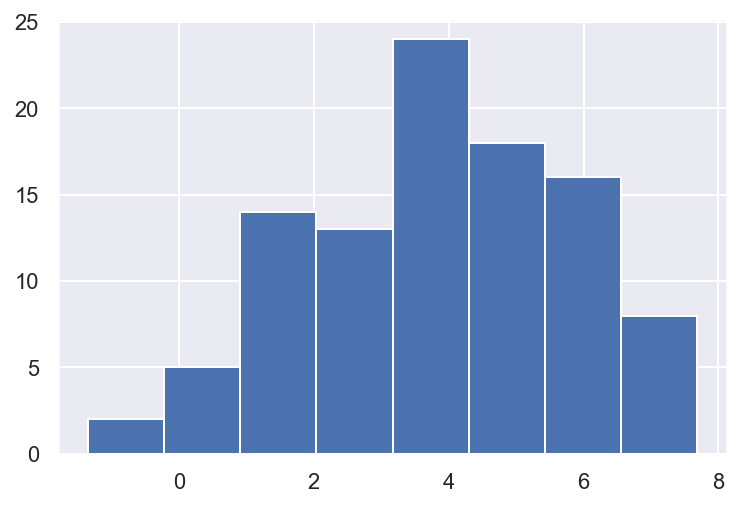

In [11]:
fig, ax = plt.subplots()
ax.hist(obs.data.numpy(), bins='auto');

# Full batch

In [12]:
from pyro.nn import AutoRegressiveNN

In [13]:
from torch.distributions import constraints
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms.utils import clamp_preserve_gradients

In [14]:
class InverseAutoregressiveFlow(TransformModule):
    """
    An implementation of Inverse Autoregressive Flow, using Eq (10) from Kingma Et Al., 2016,
        :math:`\\mathbf{y} = \\mu_t + \\sigma_t\\odot\\mathbf{x}`
    where :math:`\\mathbf{x}` are the inputs, :math:`\\mathbf{y}` are the outputs, :math:`\\mu_t,\\sigma_t`
    are calculated from an autoregressive network on :math:`\\mathbf{x}`, and :math:`\\sigma_t>0`.
    Together with `TransformedDistribution` this provides a way to create richer variational approximations.
    Example usage:
    >>> from pyro.nn import AutoRegressiveNN
    >>> base_dist = dist.Normal(torch.zeros(10), torch.ones(10))
    >>> iaf = InverseAutoregressiveFlow(AutoRegressiveNN(10, [40]))
    >>> pyro.module("my_iaf", iaf)  # doctest: +SKIP
    >>> iaf_dist = dist.TransformedDistribution(base_dist, [iaf])
    >>> iaf_dist.sample()  # doctest: +SKIP
        tensor([-0.4071, -0.5030,  0.7924, -0.2366, -0.2387, -0.1417,  0.0868,
                0.1389, -0.4629,  0.0986])
    The inverse of the Bijector is required when, e.g., scoring the log density of a sample with
    `TransformedDistribution`. This implementation caches the inverse of the Bijector when its forward
    operation is called, e.g., when sampling from `TransformedDistribution`. However, if the cached value
    isn't available, either because it was overwritten during sampling a new value or an arbitary value is
    being scored, it will calculate it manually. Note that this is an operation that scales as O(D) where D is
    the input dimension, and so should be avoided for large dimensional uses. So in general, it is cheap
    to sample from IAF and score a value that was sampled by IAF, but expensive to score an arbitrary value.
    :param autoregressive_nn: an autoregressive neural network whose forward call returns a real-valued
        mean and logit-scale as a tuple
    :type autoregressive_nn: nn.Module
    :param log_scale_min_clip: The minimum value for clipping the log(scale) from the autoregressive NN
    :type log_scale_min_clip: float
    :param log_scale_max_clip: The maximum value for clipping the log(scale) from the autoregressive NN
    :type log_scale_max_clip: float
    References:
    1. Improving Variational Inference with Inverse Autoregressive Flow [arXiv:1606.04934]
    Diederik P. Kingma, Tim Salimans, Rafal Jozefowicz, Xi Chen, Ilya Sutskever, Max Welling
    2. Variational Inference with Normalizing Flows [arXiv:1505.05770]
    Danilo Jimenez Rezende, Shakir Mohamed
    3. MADE: Masked Autoencoder for Distribution Estimation [arXiv:1502.03509]
    Mathieu Germain, Karol Gregor, Iain Murray, Hugo Larochelle
    """

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1
    autoregressive = True

    def __init__(self, autoregressive_nn, log_scale_min_clip=-5., log_scale_max_clip=3.):
        super(InverseAutoregressiveFlow, self).__init__(cache_size=1)
        self.arn = autoregressive_nn
        self._cached_log_scale = None
        self.log_scale_min_clip = log_scale_min_clip
        self.log_scale_max_clip = log_scale_max_clip

    def _call(self, x):
        """
        :param x: the input into the bijection
        :type x: torch.Tensor
        Invokes the bijection x=>y; in the prototypical context of a TransformedDistribution `x` is a
        sample from the base distribution (or the output of a previous flow)
        """
        mean, log_scale = self.arn(x)
        log_scale = clamp_preserve_gradients(log_scale, self.log_scale_min_clip, self.log_scale_max_clip)
        self._cached_log_scale = log_scale
        scale = torch.exp(log_scale)

        y = scale * x + mean
        return y

    def _inverse(self, y):
        """
        :param y: the output of the bijection
        :type y: torch.Tensor
        Inverts y => x. Uses a previously cached inverse if available, otherwise performs the inversion afresh.
        """
        x_size = y.size()[:-1]
        perm = self.arn.permutation
        input_dim = y.size(-1)
        x = [torch.zeros(x_size, device=y.device)] * input_dim

        # NOTE: Inversion is an expensive operation that scales in the dimension of the input
        for idx in perm:
            mean, log_scale = self.arn(torch.stack(x, dim=-1))
            inverse_scale = torch.exp(-clamp_preserve_gradients(
                log_scale[..., idx], min=self.log_scale_min_clip, max=self.log_scale_max_clip))
            mean = mean[..., idx]
            x[idx] = (y[..., idx] - mean) * inverse_scale

        x = torch.stack(x, dim=-1)
        log_scale = clamp_preserve_gradients(log_scale, min=self.log_scale_min_clip, max=self.log_scale_max_clip)
        self._cached_log_scale = log_scale
        return x

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log jacobian
        """
        if self._cached_log_scale is not None:
            log_scale = self._cached_log_scale
        else:
            _, log_scale = self.arn(x)
            log_scale = clamp_preserve_gradients(log_scale, self.log_scale_min_clip, self.log_scale_max_clip)
        return log_scale.sum(-1)



In [15]:
class InverseAutoregressiveFlowStable(TransformModule):
    """
    An implementation of an Inverse Autoregressive Flow, using Eqs (13)/(14) from Kingma Et Al., 2016,
        :math:`\\mathbf{y} = \\sigma_t\\odot\\mathbf{x} + (1-\\sigma_t)\\odot\\mu_t`
    where :math:`\\mathbf{x}` are the inputs, :math:`\\mathbf{y}` are the outputs, :math:`\\mu_t,\\sigma_t`
    are calculated from an autoregressive network on :math:`\\mathbf{x}`, and :math:`\\sigma_t` is
    restricted to :math:`(0,1)`.
    This variant of IAF is claimed by the authors to be more numerically stable than one using Eq (10),
    although in practice it leads to a restriction on the distributions that can be represented,
    presumably since the input is restricted to rescaling by a number on :math:`(0,1)`.
    Example usage:
    >>> from pyro.nn import AutoRegressiveNN
    >>> base_dist = dist.Normal(torch.zeros(10), torch.ones(10))
    >>> iaf = InverseAutoregressiveFlowStable(AutoRegressiveNN(10, [40]))
    >>> iaf_module = pyro.module("my_iaf", iaf)
    >>> iaf_dist = dist.TransformedDistribution(base_dist, [iaf])
    >>> iaf_dist.sample()  # doctest: +SKIP
        tensor([-0.4071, -0.5030,  0.7924, -0.2366, -0.2387, -0.1417,  0.0868,
                0.1389, -0.4629,  0.0986])
    See `InverseAutoregressiveFlow` docs for a discussion of the running cost.
    :param autoregressive_nn: an autoregressive neural network whose forward call returns a real-valued
        mean and logit-scale as a tuple
    :type autoregressive_nn: nn.Module
    :param sigmoid_bias: bias on the hidden units fed into the sigmoid; default=`2.0`
    :type sigmoid_bias: float
    References:
    1. Improving Variational Inference with Inverse Autoregressive Flow [arXiv:1606.04934]
    Diederik P. Kingma, Tim Salimans, Rafal Jozefowicz, Xi Chen, Ilya Sutskever, Max Welling
    2. Variational Inference with Normalizing Flows [arXiv:1505.05770]
    Danilo Jimenez Rezende, Shakir Mohamed
    3. MADE: Masked Autoencoder for Distribution Estimation [arXiv:1502.03509]
    Mathieu Germain, Karol Gregor, Iain Murray, Hugo Larochelle
    """

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, autoregressive_nn, sigmoid_bias=2.0):
        super(InverseAutoregressiveFlowStable, self).__init__(cache_size=1)
        self.arn = autoregressive_nn
        self.sigmoid = nn.Sigmoid()
        self.logsigmoid = nn.LogSigmoid()
        self.sigmoid_bias = sigmoid_bias
        self._cached_log_scale = None

    def _call(self, x):
        """
        :param x: the input into the bijection
        :type x: torch.Tensor
        Invokes the bijection x=>y; in the prototypical context of a TransformedDistribution `x` is a
        sample from the base distribution (or the output of a previous flow)
        """
        mean, logit_scale = self.arn(x)
        logit_scale = logit_scale + self.sigmoid_bias
        scale = self.sigmoid(logit_scale)
        log_scale = self.logsigmoid(logit_scale)
        self._cached_log_scale = log_scale

        y = scale * x + (1 - scale) * mean
        return y

    def _inverse(self, y):
        """
        :param y: the output of the bijection
        :type y: torch.Tensor
        Inverts y => x.
        """
        x_size = y.size()[:-1]
        perm = self.arn.permutation
        input_dim = y.size(-1)
        x = [torch.zeros(x_size, device=y.device)] * input_dim

        # NOTE: Inversion is an expensive operation that scales in the dimension of the input
        for idx in perm:
            mean, logit_scale = self.arn(torch.stack(x, dim=-1))
            inverse_scale = 1 + torch.exp(-logit_scale[..., idx] - self.sigmoid_bias)
            x[idx] = inverse_scale * y[..., idx] + (1 - inverse_scale) * mean[..., idx]
            self._cached_log_scale = inverse_scale

        x = torch.stack(x, dim=-1)
        return x

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log jacobian
        """
        if self._cached_log_scale is not None:
            log_scale = self._cached_log_scale
        else:
            _, logit_scale = self.arn(x)
            log_scale = self.logsigmoid(logit_scale + self.sigmoid_bias)
        return log_scale.sum(-1)

In [132]:
class Model:
    def __init__(self, dim, flow_length):
        super().__init__()
        self.dim = dim
        
        self.transforms = [InverseAutoregressiveFlowStable(AutoRegressiveNN(dim, [50]))for _ in range(flow_length)]
        # self.transforms = [T.Sylvester(dim) for _ in range(flow_length)]
    
    @staticmethod
    def model():
        pass
    
    @staticmethod
    def guide():
        pass
        
    def loss(self, model, guide, x, n_sample):
        
        pyro.module("nf", nn.ModuleList(self.transforms))
        zk = self.sample(n_sample)

        mu, sigma = self.move_to_constraint_space(zk)
        
        lls =  dist.Normal(mu, sigma).log_prob(x.unsqueeze(-1)).sum(axis=0)
        
        ln_q = torch.zeros(n_sample)
        for i in range(n_sample):
            ln_q[i] = self.flow_dist.log_prob(zk[i]).sum()
    
        return (ln_q - lls).mean()
    
    @property
    def flow_dist(self):
        
        base_dist = dist.Normal(torch.zeros(self.dim), 2*torch.ones(self.dim))
        flow_dist = dist.TransformedDistribution(base_dist, self.transforms)
        return flow_dist
        
    def sample(self, n=40):
        
        zk = torch.zeros(n, dim)
        for i in range(n):

            with pyro.plate("n_sample"):
                zk[i] = pyro.sample("zk", self.flow_dist)

        return zk
    
    @staticmethod
    def move_to_constraint_space(zk):
        
        mu, unc_sigma = zk.T
        sigma = torch.exp(0.5*unc_sigma) # + 1e07 # torch.nn.functional.softplus(unc_sigma)
        return mu, sigma

In [139]:
flow_length = 16
epochs = 100
initial_lr = 0.01
n_sample=40
dim = 2

In [140]:
torch.manual_seed(123);
pyro.clear_param_store()

In [141]:
model = Model(dim=dim, flow_length=flow_length)

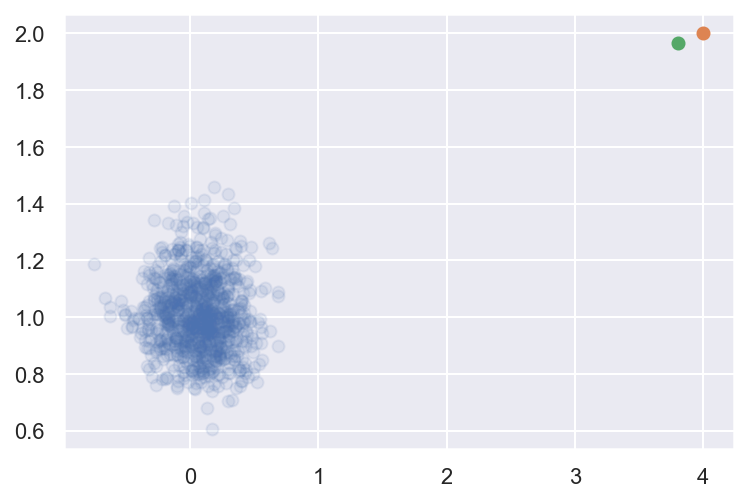

In [142]:
zk = model.sample(1000)
mu, sigma = model.move_to_constraint_space(zk)

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma);

In [143]:
optimizer = pyro.optim.ClippedAdam({"lr": initial_lr})  #  "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model.model, model.guide, optimizer, model.loss)

n_sample = 40

pyro.clear_param_store()

hist_loss = []

with tqdm(total=epochs) as pbar:

    for i in range(epochs):

        loss = svi.step(obs, n_sample)

        hist_loss.append(loss)

        pbar.set_postfix(loss=loss)
        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: The value argument must be within the support

In [ ]:
zk = model.sample(500)
mu, sigma = model.move_to_constraint_space(zk)

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma);

In [ ]:
plt.plot(hist_loss)

In [ ]:
q_mu_samples = mu.detach()
q_sigma_samples = sigma.detach()

In [ ]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    q_mu_samples=q_mu_samples, q_sigma_samples=q_sigma_samples)

# Minibatch

In [1201]:
batch_size=10
epochs=10
flow_length=40
initial_lr=0.001 
n_sample=40 
seed=123
    
torch.manual_seed(seed)

model = Model(dim=n_dim, flow_length=flow_length)

optimizer = pyro.optim.Adam({"lr": initial_lr})  #  "betas": (0.90, 0.999)})
svi = pyro.infer.SVI(model.model, model.guide, optimizer, model.loss)

pyro.clear_param_store()

hist_loss = []

with tqdm(total=epochs) as pbar:

    for epoch in range(epochs):

        permutation = torch.randperm(n_obs)

        for i in range(0, n_obs, batch_size):

            indices = permutation[i:i+batch_size]
            minibatch = obs[indices]
            
            loss = svi.step(minibatch, n_sample)
            
            hist_loss.append(loss)

        pbar.set_postfix(loss=np.mean(hist_loss[- batch_size:]))
        pbar.update()

  0%|          | 0/10 [00:00<?, ?it/s]

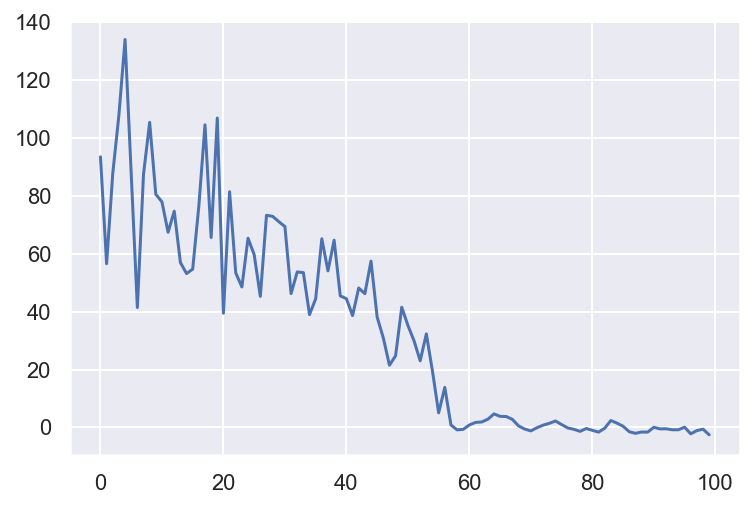

In [1202]:
plt.plot(hist_loss);

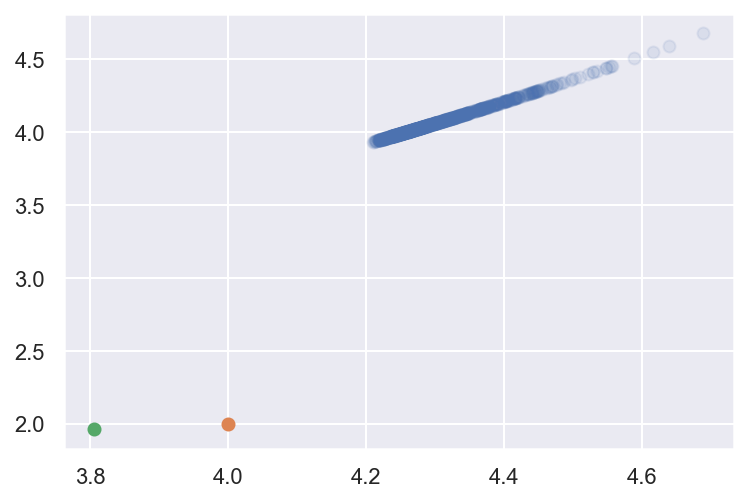

In [1203]:
zk = model.sample(1000)
mu, sigma = model.move_to_constraint_space(zk)

fig, ax = plt.subplots()
ax.scatter(mu.data, sigma.data, alpha=0.1)
ax.scatter(true_mu, true_sigma)
ax.scatter(obs_mu, obs_sigma);

In [1204]:
q_mu_samples = mu.detach()
q_sigma_samples = sigma.detach()

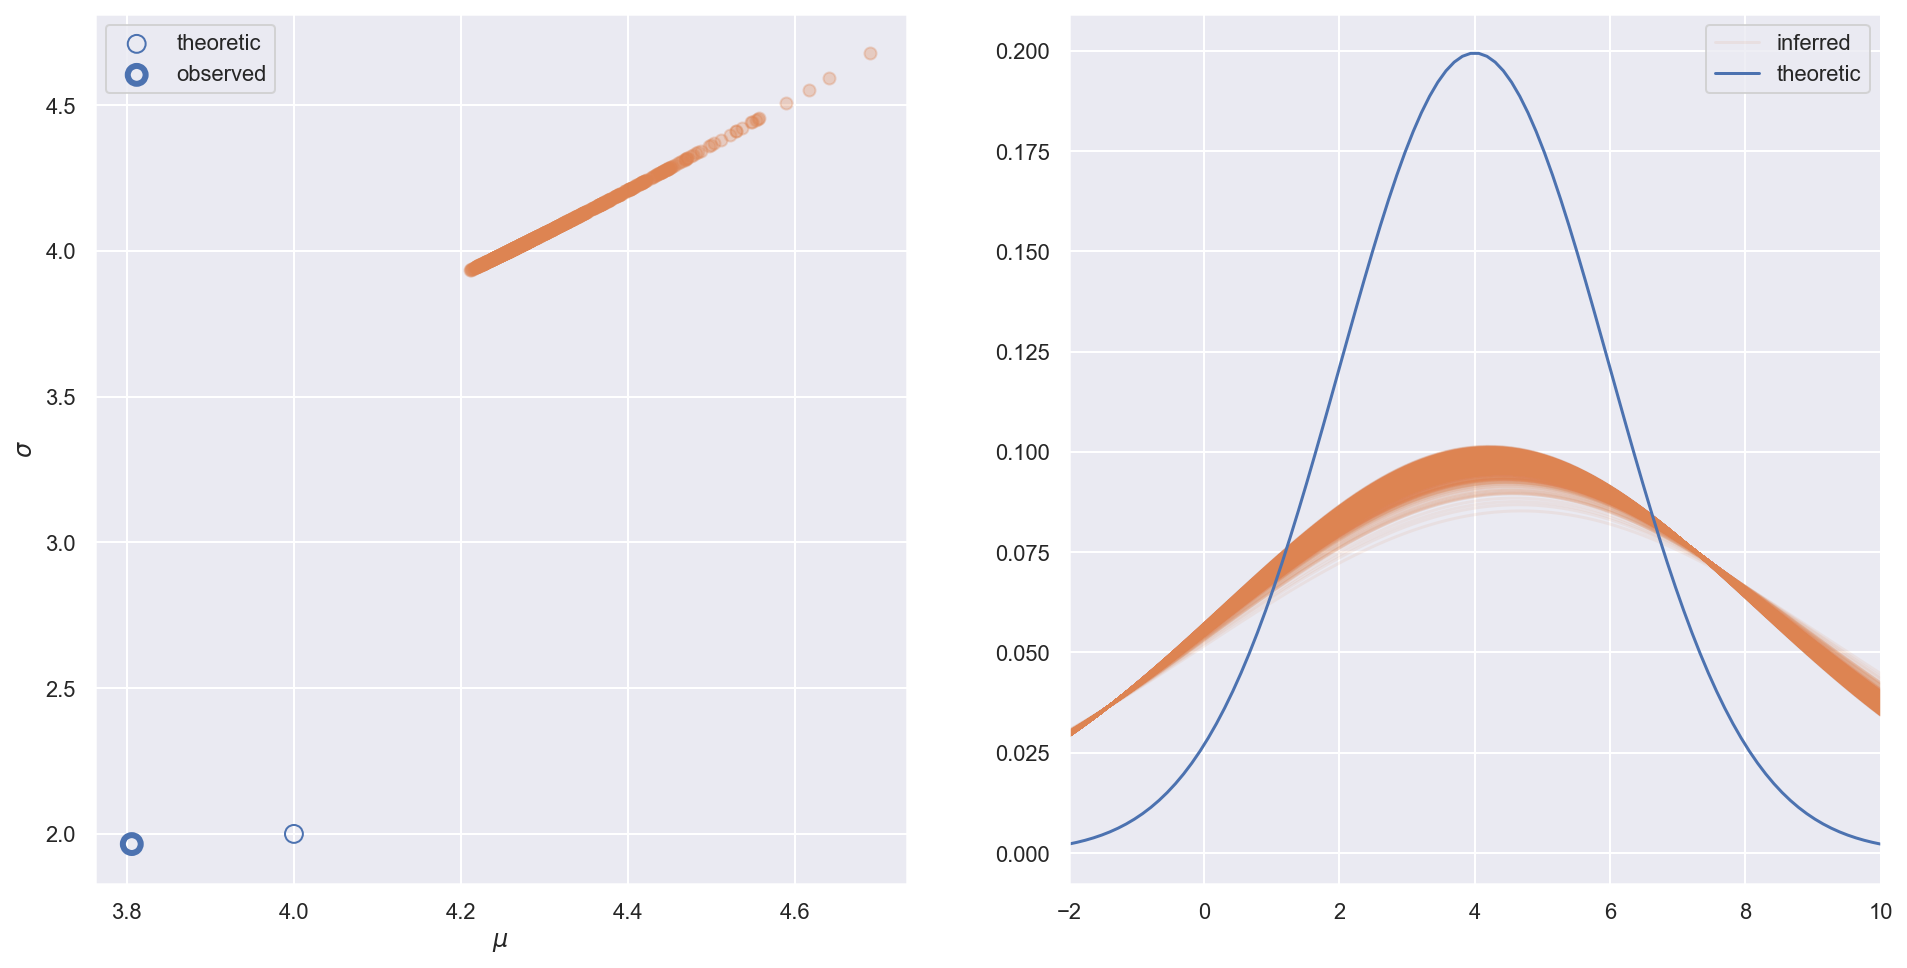

In [1205]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    q_mu_samples=q_mu_samples, q_sigma_samples=q_sigma_samples)

# Original example

In [689]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

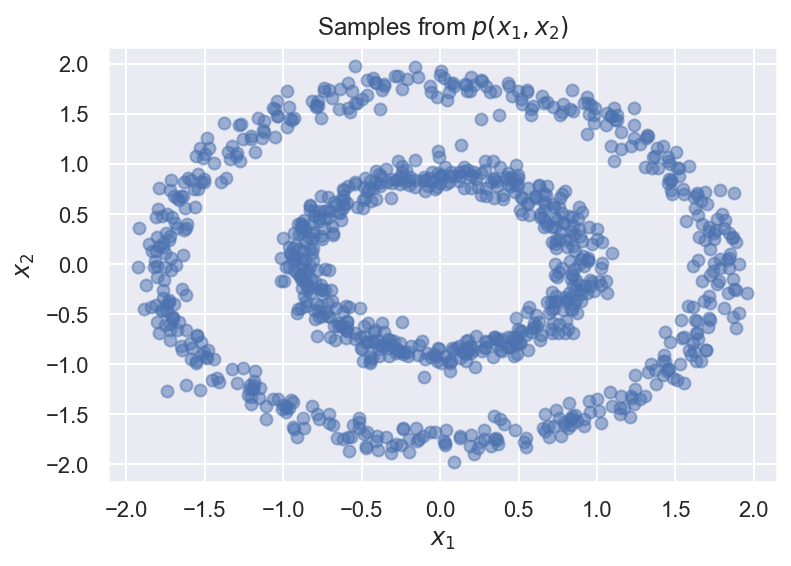

In [690]:
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

In [696]:
dataset = torch.tensor(X, dtype=torch.float)

In [697]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [698]:
pyro.clear_param_store()

optimizer = optim.Adam(
    spline_transform.parameters(),
    lr=0.01)

hist_loss = []

with tqdm(total=epochs) as pbar:

    for i in range(epochs):

        optimizer.zero_grad()

        loss = - flow_dist.log_prob(dataset).mean()
        loss.backward()
        optimizer.step()
        flow_dist.clear_cache()

        hist_loss.append(loss.item())

        pbar.set_postfix(loss=loss.item())
        pbar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

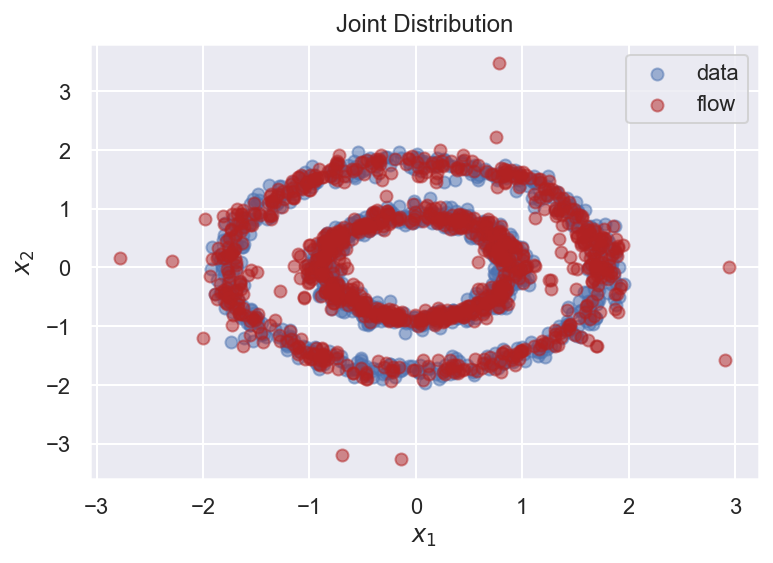

In [719]:
fig, ax = plt.subplots()

X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
ax.set_title(r'Joint Distribution')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
ax.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
ax.legend();

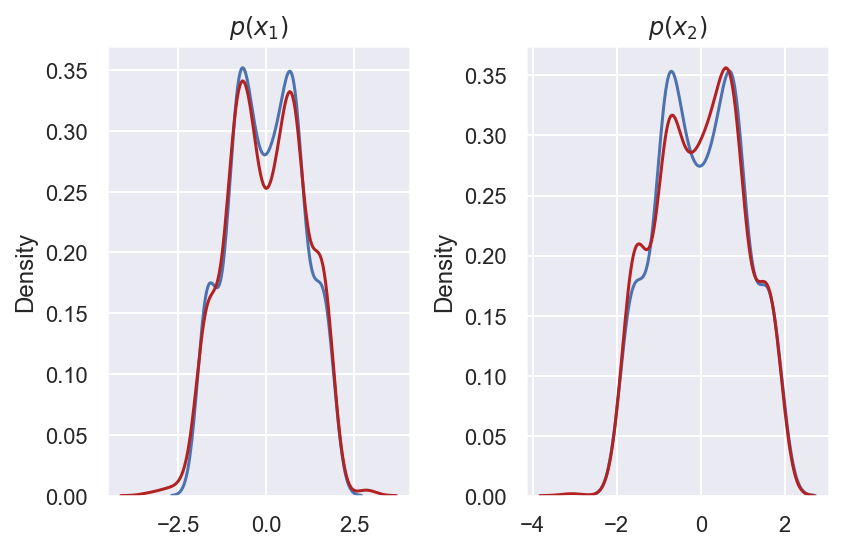

In [717]:
fig, axes = plt.subplots(ncols=2)
sns.kdeplot(X[:,0], label='data', ax=axes[0])
sns.kdeplot(X_flow[:,0], color='firebrick', label='flow', ax=axes[0])
axes[0].set_title(r'$p(x_1)$')

sns.kdeplot(X[:,1], label='data', ax=axes[1])
sns.kdeplot(X_flow[:,1], color='firebrick', label='flow', ax=axes[1])
axes[1].set_title(r'$p(x_2)$')
fig.tight_layout()

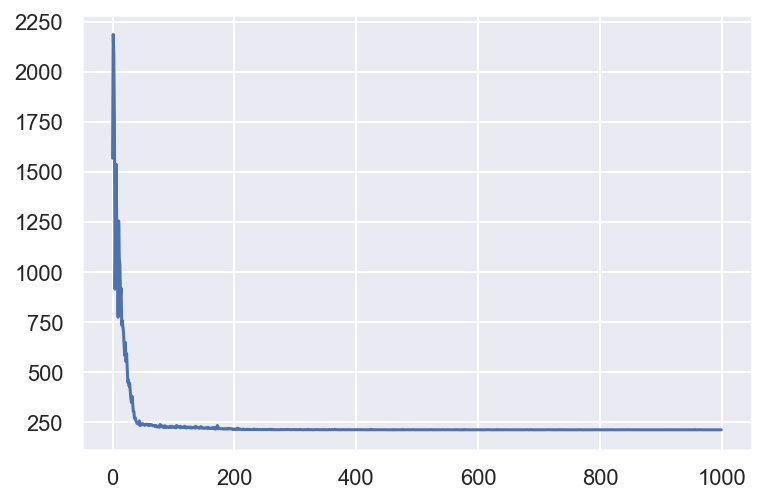

In [47]:
plt.plot(hist_loss);